<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-lib" data-toc-modified-id="Load-lib-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load lib</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Convert-crash-files-(do-once)" data-toc-modified-id="Convert-crash-files-(do-once)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Convert crash files (do once)</a></span></li><li><span><a href="#Load-csv" data-toc-modified-id="Load-csv-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load csv</a></span></li></ul></li><li><span><a href="#Vietnamese-tokenization" data-toc-modified-id="Vietnamese-tokenization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Vietnamese tokenization</a></span><ul class="toc-item"><li><span><a href="#Step-1:-Pretokenization-(Vietnamese-word-tokenization)" data-toc-modified-id="Step-1:-Pretokenization-(Vietnamese-word-tokenization)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Step 1: Pretokenization (Vietnamese word tokenization)</a></span></li><li><span><a href="#Step-2:-Model's-tokenization" data-toc-modified-id="Step-2:-Model's-tokenization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Step 2: Model's tokenization</a></span></li></ul></li><li><span><a href="#Use-HuggingFace-Dataset-to-store-and-tokenize-corpus" data-toc-modified-id="Use-HuggingFace-Dataset-to-store-and-tokenize-corpus-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Use HuggingFace Dataset to store and tokenize corpus</a></span></li><li><span><a href="#Define-dataset-dict-and-perform-train/val-split" data-toc-modified-id="Define-dataset-dict-and-perform-train/val-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define dataset dict and perform train/val split</a></span></li><li><span><a href="#Model-Understanding" data-toc-modified-id="Model-Understanding-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Understanding</a></span><ul class="toc-item"><li><span><a href="#Extract-hidden-states-for-sentence-similarity" data-toc-modified-id="Extract-hidden-states-for-sentence-similarity-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Extract hidden states for sentence similarity</a></span></li></ul></li><li><span><a href="#Sentiment-classification-training" data-toc-modified-id="Sentiment-classification-training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Sentiment classification training</a></span><ul class="toc-item"><li><span><a href="#Classification-using-default-PhoBert" data-toc-modified-id="Classification-using-default-PhoBert-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Classification using default PhoBert</a></span></li><li><span><a href="#Define-helper-function-for-training" data-toc-modified-id="Define-helper-function-for-training-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Define helper function for training</a></span></li><li><span><a href="#Start-training" data-toc-modified-id="Start-training-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Start training</a></span></li></ul></li><li><span><a href="#Prediction-interpretation" data-toc-modified-id="Prediction-interpretation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Prediction interpretation</a></span><ul class="toc-item"><li><span><a href="#Classification-report-and-confusion-matrix" data-toc-modified-id="Classification-report-and-confusion-matrix-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Classification report and confusion matrix</a></span></li><li><span><a href="#Most-confident-prediction:-right-vs-wrong" data-toc-modified-id="Most-confident-prediction:-right-vs-wrong-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Most confident prediction: right vs wrong</a></span></li></ul></li></ul></div>

# Load lib

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from tqdm import tqdm
import re
import os 
from pathlib import Path
import numpy as np

In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [4]:
from functools import partial

In [5]:
import matplotlib.pyplot as plt

In [6]:
from transformers.models.roberta.configuration_roberta import RobertaConfig
from transformers.models.roberta.modeling_roberta import RobertaModel # body only
#inherit this to load pretrained weight
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput

import torch


In [7]:
# !pip install underthesea

In [8]:
DATA_PATH = Path('data_crash')
RAW_PATH = Path('raw_crash')

In [9]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Load data

## Convert crash files (do once)

In [10]:


# if not os.path.exists(DATA_PATH):
#     os.mkdir(DATA_PATH)

# ### Cleaning training file

# train = open(RAW_PATH/"train.crash").readlines()
# id_locations = []
# label_locations = []
# for idx, line in tqdm(enumerate(train)):
#     line = line.strip()
#     if line.startswith("train_"):
#         id_locations.append(idx)
#     elif line == "0" or line == "1":
#         label_locations.append(idx)
# data = []

# for id_loc, l_loc in tqdm(zip(id_locations, label_locations)):
#     line_id = train[id_loc].strip()
#     label = train[l_loc].strip()
#     text = re.sub('\s+', ' ', ' '.join(train[id_loc + 1: l_loc])).strip()[1:-1].strip()
#     data.append(f"{line_id}\t{text}\t{label}")

# with open(DATA_PATH/"train.csv", "wt") as f:
#     f.write("id\ttext\tlabel\n")
#     f.write("\n".join(data))

# ### Cleaning test file

# test = open(RAW_PATH/"test.crash").readlines()
# id_locations = []
# for idx, line in tqdm(enumerate(test)):
#     line = line.strip()
#     if line.startswith("test_"):
#         id_locations.append(idx)
# data = []

# for i, id_loc in tqdm(enumerate(id_locations)):
#     if i >= len(id_locations) - 1:
#         end = len(test)
#     else:
#         end = id_locations[i + 1]
#     line_id = test[id_loc].strip()
#     text = re.sub('\s+', ' ', ' '.join(test[id_loc + 1:end])).strip()[1:-1].strip()
#     data.append(f"{line_id}\t{text}")

# with open(DATA_PATH/"test.csv", "wt") as f:
#     f.write("id\ttext\n")
#     f.write("\n".join(data))

## Load csv

In [11]:
!ls {str(DATA_PATH)}

test.csv  train.csv


In [12]:
train_df = pd.read_csv(DATA_PATH/'train.csv',sep='\t').fillna("###")
test_df = pd.read_csv(DATA_PATH/'test.csv',sep='\t').fillna("###")

In [13]:
train_df[['text','label']].sample(20)

,text,label
9602,San pham dung nhu tren hinh,0
13611,ga giường mỏng như lá lúa,1
13163,Đế giày còn nhiều lỗi 🙂,1
13740,Do vchuyen len bị rớt bên ngoài chút ạ nhưng k...,0
1799,Chất lượng sản phẩm tuyệt vời😘 Đóng gói sản ph...,0
13362,- giày rất đẹp sau này sẽ ủng hộ shop tiếp nữa,0
9671,Mua 2 cái sạc iphone thì giao 2 cái sạc samsun...,1
10343,Nó tệ hơn so với những gì mình tưởng. mua nó m...,1
7944,Giao hang rất nhanh. Dong goi rất can than.,0
2296,Lần sau ủng hộ shop nữa. Ngon.Đóng gói sản phẩ...,0


In [14]:
print(train_df[['text','label']].sample(5).values)

[['Chất lượng sản phẩm rất kém. Mình mua 2sp 1sp dùng được 1 sp bị hỏng'
  1]
 ['Chất lượng sản phẩm tuyệt vời thanks shop đã lên deal!' 0]
 ['Giày chiếc to chiếc nhỏ' 1]
 ['Quá xấu đường may quá thưa chất vải quá xấu ko phải chất quần jieans'
  1]
 ['Ối zời ơi, ngon quá xá luôn Ngon ngoài sức tưởng tượng Thik nhất sấu và mơ chua cay'
  0]]


In [15]:
print(test_df[['text']].sample(5).values)

[['Không giống ảnh ở nhiều chi tiết']
 ['Hàng y hình rất đẹp và chắc chắn.']
 ['dễ thương ko có j để bàn cãi chỉ mỗi tội bị nhỏ em giành mất ko có xài TT.TT']
 ['kem không thấm khó tán đều sau khoảng 1-2h lại bết vào nếp da trắng bệt nhìn không tự nhiên chút nào cả khó trôi kể cả dùng xà phòng. phải dùng muối biển tẩy da mới hết. tác dụng chống nắng cảm giác không đạt spf 50 đâu. nói chung là xài mới có vài lần là bỏ luôn cả type. uổng tiền!!!']
 ['Rất phù hợp giá tiền. Ck mình mặc cái nào cũng đẹp. Có 6sao thì cho 6 sao luôn.']]


# Vietnamese tokenization

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098136789/files/assets/nlpt_0401.png)

Jack Sparrow loves New York!


1. Normalization
    - set of operations you apply to a raw string to **make it “cleaner”**, e.g. stripping whitespace, rm accented chars, lowercasing, Unicode normalization (unify various ways to write the same character)

=> jack sparrow loves new york!

2. Pretokenization
    - splits a text into smaller objects (can be words) that **give an upper bound to what your tokens will be at the end of training; your final tokens will be parts of these smaller objects**
    - Sometimes splitting into 'words' is not always trivial (Chinese, Japanese, Korean). In this case, it might be best to not pretokenize the text and instead use a language-specific library for pretokenization.

=> ["jack", "sparrow", "loves", "new", "york", "!"]

3. Tokenizer model
    - tokenizer applies a **subword splitting model** on the words. This is the part of the pipeline that **needs to be trained on your corpus (or that has been trained if you are using a pretrained tokenizer)**
    -  to split the words into subwords to reduce the size of the vocabulary and try to reduce the number of out-of-vocabulary tokens
    - Several subword tokenization algorithms exist, including BPE, Unigram, and WordPiece
    
=> [jack, spa, rrow, loves, new, york, !]

NOTE: at this point we no longer have a list of strings but a list of integers (input IDs)

4. Postprocessing
    - some additional transformations can be applied on the list of tokens
    - e.g. adding special tokens at the beginning or the end
    - This is the last step, and the sequence of integers can be fed to the model
=> a BERT-style tokenizer would add classifications and separator tokens: [CLS, jack, spa, rrow, loves, new, york, !, SEP]
    

## Step 1: Pretokenization (Vietnamese word tokenization)

https://github.com/undertheseanlp/underthesea

```python
>>> from underthesea import word_tokenize
>>> sentence = 'Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò'

>>> word_tokenize(sentence)
['Chàng trai', '9X', 'Quảng Trị', 'khởi nghiệp', 'từ', 'nấm', 'sò']

>>> word_tokenize(sentence, format="text")
'Chàng_trai 9X Quảng_Trị khởi_nghiệp từ nấm sò'
```

In [ ]:
!pip install underthesea

In [16]:
from underthesea import word_tokenize, sent_tokenize

In [17]:
def apply_word_tokenize(sen,split_word=False):
    # optional step: fix the whitespace between words
    sen = " ".join(sen.split())
    sens = sent_tokenize(sen)
    
    # word tokenize
    tokenized_sen = []
    for sen in sens:
        tokenized_sen+=word_tokenize(sen,format='text' if not split_word else None)
    
    if not split_word:
        return ''.join(tokenized_sen)
    return ['_'.join(words.split(' ')) for words in tokenized_sen]
        

In [18]:
_tmp = 'Chất lượng sản phẩm tuyệt vời, phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
# print(apply_word_tokenize(_tmp,False))
print(apply_word_tokenize(_tmp,True))

['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', ',', 'phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']


In [19]:
_tmp = 'Chất lượng sản phẩm tuyệt vời? Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
# print(apply_word_tokenize(_tmp,False))
print(apply_word_tokenize(_tmp,True))

['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '?', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']


In [20]:
_tmp = 'Chất lượng sản phẩm tuyệt vời 😌😌. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
# print(apply_word_tokenize(_tmp,False))
print(apply_word_tokenize(_tmp,True))

['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '😌_😌', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']


Apply on the whole dataset

In [21]:
train_text = [apply_word_tokenize(s[0],True) for s in train_df[['text']].values]
train_label = train_df.label.values

In [22]:
test_text = [apply_word_tokenize(s[0],True) for s in test_df[['text']].values]

In [23]:
train_text[10:15]

[['Chất_lượng',
  'sản_phẩm',
  'tuyệt_vời',
  '.',
  'y',
  'hình',
  'chụp',
  '.',
  'đáng',
  'tiền'],
 ['Hjhj_shop',
  'giao',
  'hàng',
  'nhanh',
  'quá',
  '.',
  'Đẹp',
  'lắm',
  'ạ',
  'bé',
  'nhà',
  'm',
  'rất',
  'thích'],
 ['nhìn', 'đẹp', 'phết', 'nhỉ', '..'],
 ['Đóng_gói',
  'rất',
  'đẹp',
  '.',
  'Chất_lượng',
  'sản_phẩm',
  'rất',
  'tốt',
  'Chất_lượng',
  'sản_phẩm',
  'tuyệt_vời'],
 ['Săn', 'đc', 'với', 'giá', '11', 'k', '.', 'Toẹt', 'vời']]

## Step 2: Model's tokenization

To use pretrained language model such as BERT, GPT, Roberta... We need to tokenize words using the strategy in these models (BPE, wordpiece, ...)

Huggingface allows us to get the tokenizer corresponding to the model by the model name on their hub. In this notebook, we use PhoBERT-base (vinai/phobert-base).

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")# model name in huggingface's hub


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
def tokenizer_explain(inp,split_word):
    print('--- Tokenized results --- ')
    print(tokenizer(inp,is_split_into_words=split_word))
    print()
    tok = tokenizer.encode(inp,is_split_into_words=split_word)
    print('--- Results from tokenizer.convert_ids_to_tokens')
    print(tokenizer.convert_ids_to_tokens(tok))
    print()
    print('--- Results from tokenizer.decode --- ')
    print(tokenizer.decode(tok))
    print()


def two_step_tokenization_explain(inp,split_word=False):
    print('--- Raw sentence ---')
    print(inp)
    print()
    print('--- Pretokenization ---')
    tok = apply_word_tokenize(inp,split_word)
    print(tok)
    print()
    tokenizer_explain(tok,split_word)

In [26]:
_tmp = 'Chất lượng sản phẩm tuyệt vời, phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,True)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời, phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', ',', 'phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 4, 7079, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', ',', 'phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời, phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



In [27]:
_tmp = 'Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,split_word=False)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
Chất_lượng sản_phẩm tuyệt_vời .Phấn mịn , đóng_gói sản_phẩm rất đẹp và chắc_chắn

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 2586, 11459, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.@@', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời.Phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



In [28]:
_tmp = 'Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,True)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 5, 11459, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời. Phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



In [29]:
_tmp = 'Chất lượng sản phẩm tuyệt vời 😌😌. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,split_word=True)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời 😌😌. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '😌_😌', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 3, 1751, 3, 5, 11459, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '<unk>', '_@@', '<unk>', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời <unk> _<unk>. Phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



# Use HuggingFace Dataset to store and tokenize corpus

In [30]:
from datasets import DatasetDict,Dataset

In [31]:
def tokenize_function(examples):
    # pad to model's allowed max length, which is max_sequence_length
    return tokenizer(examples["text"], padding="max_length", truncation=True,is_split_into_words=True)


In [32]:
train_dataset = Dataset.from_dict(
                        {'text': train_text[:4],
                        'label':train_label[:4],
                        }
                    )
# test_dataset = Dataset.from_dict(
#                         {'text': test_text,
#                         }
#                     )

In [33]:
train_dataset_tokenized = train_dataset.map(tokenize_function,batched=True,batch_size=2)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [34]:
train_dataset_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4
})

In [35]:
print(train_dataset_tokenized['text'])

[['Dung', 'dc', 'sp', 'tot', 'cam', 'on_shop', 'Đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời'], ['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.', 'Son', 'mịn', 'nhưng', 'khi', 'đánh', 'lên', 'không', 'như', 'màu', 'trên', 'ảnh'], ['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', 'nhưng', 'k', 'có', 'hộp', 'k', 'có', 'dây', 'giày', 'đen', 'k', 'có', 'tất'], [':', '(', '(', 'Mình', 'hơi', 'thất_vọng', '1', 'chút', 'vì', 'mình', 'đã', 'kỳ_vọng', 'cuốn', 'sách', 'khá', 'nhiều', 'hi_vọng', 'nó', 'sẽ', 'nói', 'về', 'việc', 'học_tập', 'của', 'cách', 'sinh_viên', 'trường', 'Harvard', 'ra_sao', 'những', 'nỗ_lực', 'của', 'họ', 'như', 'thế_nào', '4', 'h', 'sáng', '?', 'tại_sao', 'họ', 'lại', 'phải', 'thức', 'dậy', 'vào', 'thời_khắc', 'đấy', '?', 'sau', 'đó', 'là', 'cả', 'một', 'câu_chuyện', 'ra_sao', '.', 'Cái', 'mình', 'thực_sự', 'cần', 'ở', 'đây', 'là', 'câu_chuyện', 'ẩn', 'dấu', 'trong', 'đó', 'để', 'tự', 'bản_thân', 'mỗi', 'người', 'cảm_nhận', 'và', 'đi', 'sâu

In [36]:
print(train_dataset_tokenized['input_ids'])

[[0, 3556, 1236, 1894, 36150, 2225, 1204, 2947, 1672, 20811, 54922, 55662, 1685, 265, 59, 258, 6, 994, 6869, 265, 1819, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 6869, 265, 1819, 5, 16332, 5451, 51, 26, 480, 72, 17, 42, 412, 34, 284, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Define dataset dict and perform train/val split

In [37]:
train_dataset = Dataset.from_dict(
                        {'text': train_text,
                        'label':train_label,
                        }
                    )
test_dataset = Dataset.from_dict(
                        {'text': test_text,
                        }
                    )

train_dataset_tokenized = train_dataset.map(tokenize_function,batched=True)
test_dataset_tokenized= test_dataset.map(tokenize_function,batched=True)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [38]:
seed_everything(42)
train_dataset_tokenized = train_dataset_tokenized.shuffle()

In [39]:
main_dataset_tokenized = DatasetDict()
main_dataset_tokenized['train'] = train_dataset_tokenized.select(range(int(train_dataset_tokenized.num_rows*0.8)))
main_dataset_tokenized['validation'] = train_dataset_tokenized.select(range(int(train_dataset_tokenized.num_rows*0.8),train_dataset_tokenized.num_rows))

In [40]:
main_dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12869
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3218
    })
})

In [41]:
pd.Series(main_dataset_tokenized['train']['label']).value_counts(normalize=True)

0    0.580154
1    0.419846
dtype: float64

In [42]:
pd.Series(main_dataset_tokenized['validation']['label']).value_counts(normalize=True)

0    0.563704
1    0.436296
dtype: float64

# Model Understanding

https://jalammar.github.io/illustrated-bert/

https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Extract hidden states for sentence similarity

In [49]:
def extract_hidden_states(batch,model=None):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).hidden_states[-1]

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

def extract_hidden_states_concat(batch,model=None):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last 4 hidden states
    with torch.no_grad():
        last_hidden_states = model(**inputs).hidden_states[-4:]
        last_hidden_states = [hs[:,0] for hs in last_hidden_states]
        concat_hidden_states = torch.cat(last_hidden_states,1)

    return {"hidden_state": concat_hidden_states.cpu().numpy()}

In [83]:
def raw_model_init():
    model = AutoModel.from_pretrained("vinai/phobert-base",output_hidden_states=True,output_attentions=True)
    model = model.to(device)
    return model

raw_model = raw_model_init()

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
raw_model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [50]:
seed_everything(42)
train_sample = train_dataset_tokenized.shuffle().select(range(int(train_dataset_tokenized.num_rows*1)))
sample_dataset_tokenized = DatasetDict()
trn_sz = 1
sample_dataset_tokenized['train'] = train_sample.select(range(int(train_sample.num_rows*trn_sz)))


In [51]:
sample_dataset_tokenized.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

sample_dataset_tokenized['train'] = sample_dataset_tokenized['train'].map(partial(extract_hidden_states_concat,model=raw_model), batched=True,batch_size=2)

  0%|          | 0/8044 [00:00<?, ?ba/s]

In [53]:
from sklearn.neighbors import NearestNeighbors

def concat_str(inp):
    return ' '.join(inp)
def show_neighbors(neigh,idx,data=data,metadata=sample_dataset_tokenized['train'],n_neighbors=5):
    print(f"Sentence: {concat_str(metadata['text'][idx])}\nLabel: {metadata['label'][idx]}")
    distances,nbors = neigh.kneighbors([data[idx]])

    print('\nNeighbors: ')
    for d,n_idx in zip(distances[0],nbors[0]):
        print(f"\t{concat_str(metadata['text'][n_idx])}, d={d:.3f}, label={metadata['label'][n_idx]}")

In [54]:
data = sample_dataset_tokenized['train']['hidden_state'].cpu().numpy()
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(data)

NearestNeighbors(n_neighbors=4)

In [55]:
show_neighbors(neigh,1,data=data)

Sentence: Đặt 1 hộp grow plus + 4 chai pediasure thì có 1_Chai đã bị khui ra và dán nắp lại bằng keo dán sắt . Tôi lấy đồ cố_gắng mở nắp ra thì thấy màu_nước đục và mùi hôi_thối bốc lên nồng_nặc . Bán hàng sao ko có lương_tâm vậy bạn ? Đây là sữa dành cho em bé uống mà bạn bán hàng thất_đức thế .
Label: 1

Neighbors: 
	Đặt 1 hộp grow plus + 4 chai pediasure thì có 1_Chai đã bị khui ra và dán nắp lại bằng keo dán sắt . Tôi lấy đồ cố_gắng mở nắp ra thì thấy màu_nước đục và mùi hôi_thối bốc lên nồng_nặc . Bán hàng sao ko có lương_tâm vậy bạn ? Đây là sữa dành cho em bé uống mà bạn bán hàng thất_đức thế ., d=0.000, label=1
	Đóng_gói sản_phẩm rất kém . Gói bỉm bẩn_thỉu kinh_khủng đã rách vì bị cắt tem nên miếng bỉm bên trong cũng dính bụi bẩn luôn . Mình đã vứt đi coi như vứt tiền vào sọt_rác vì chả biết liệu đã có những con gì chui vào trong gói bỉm rồi . Chưa kể giao hàng chậm . Quá thất_vọng ! ! !, d=5.800, label=1
	Sản_phẩm bị hư móc khoá . Mình có liên_hệ bên shop để đổi hàng nhưng sho

In [56]:
show_neighbors(neigh,2,data=data)

Sentence: Đáng đồng xèng . Gói cẩn_thận . Lại lịch_sự hihi , được tặng 1 đôi tất korea siêu xinhh . 5 saooo . Thời_gian giao hàng rất nhanh Rất đáng tiền Shop phục_vụ rất tốt Đóng_gói sản_phẩm rất đẹp và chắc_chắn Chất_lượng sản_phẩm tuyệt_vời
Label: 0

Neighbors: 
	Đáng đồng xèng . Gói cẩn_thận . Lại lịch_sự hihi , được tặng 1 đôi tất korea siêu xinhh . 5 saooo . Thời_gian giao hàng rất nhanh Rất đáng tiền Shop phục_vụ rất tốt Đóng_gói sản_phẩm rất đẹp và chắc_chắn Chất_lượng sản_phẩm tuyệt_vời, d=0.000, label=0
	Chất_lượng sản_phẩm tuyệt_vời Đóng_gói sản_phẩm rất đẹp và chắc_chắn Shop phục_vụ rất tốt Rất đáng tiền Thời_gian giao hàng rất nhanh . Vừa như in đẹp hết nói luôn . Giá rẻ hơn các shop khác nữa lại đc tặng 4 đôi tất . Hết_ý, d=6.340, label=0
	Mua nhiều lần rồi . Dùng Ok lắm ưng hơn các loại bỉm khác . Phù_hợp giá tiền . Ủng_hộ shop dài_dài nhưng cái anh bán nhé . Bảo khách_hàng ruột tặng thêm 1 cái bỉm hứa lên hứa xuống chả thấy tặng kèm j . Chả_lẽ cho 4 sao ._😁, d=6.591, la

In [57]:
show_neighbors(neigh,5,data=data)

Sentence: Kém chất_lượng . hàng giả hàng nhái nhé
Label: 0

Neighbors: 
	Kém chất_lượng . hàng giả hàng nhái nhé, d=0.000, label=0
	Hàng nhái thương_hiệu . chất_lượng vất đi . bán lừa hàng chính hãng, d=6.982, label=1
	hàng tệ . loa kém chất_lượng, d=7.075, label=1
	Shop làm_ăn gian_dối giao thiếu hàng còn không có trách_nhiệm . Chất_lượng sản_phẩm rất kém Shop phục_vụ rất kém . Mình khuyên không nên mua hàng ở shop này nhé, d=7.156, label=1


In [58]:
show_neighbors(neigh,14,data=data)

Sentence: Đã nhận được hàng ưng lắm nhé . Giao hàng rất nhanh . Cảm_ơn shop .
Label: 0

Neighbors: 
	Đã nhận được hàng ưng lắm nhé . Giao hàng rất nhanh . Cảm_ơn shop ., d=0.000, label=0
	Mình rất thích . Cảm_ơn shop nhé . Chất_lượng sản_phẩm tuyệt_vời . Đóng_gói sản_phẩm rất đẹp và chắc_chắn ., d=4.275, label=0
	Shop đóng_gói sản_phẩm đẹp và cẩn_thận . Hàng chuẩn . Thời_gian giao hàng nhanh . Lại được thêm món quà nhỏ từ shop nữa . Cảm_ơn shop nhé ., d=4.295, label=0
	Shop giao hàng rất nhanh . Cảm_ơn shop . Sẽ tiếp_tục ủng_hộ shop ., d=4.443, label=0


In [59]:
show_neighbors(neigh,15,data=data)

Sentence: Đặt dâu_tây mà giao lộn dưa_hấu : ( ( (
Label: 1

Neighbors: 
	Đặt dâu_tây mà giao lộn dưa_hấu : ( ( (, d=0.000, label=1
	Chiếc cao chiếc thấp : ( ( ( (, d=4.880, label=1
	Huhu mất cái mặt táo rồi : ( ( (, d=4.978, label=0
	Sản_phẩm kg giống như hình và clip : ( ( (, d=5.256, label=1


In [60]:
show_neighbors(neigh,16,data=data)

Sentence: Cấu_hình tốt , đẹp , tiện
Label: 0

Neighbors: 
	Cấu_hình tốt , đẹp , tiện, d=0.000, label=0
	Hàng đẹp - tốt, d=7.983, label=0
	Tốt giá ổn, d=8.120, label=0
	Khá là xinh, d=8.220, label=0


# Sentiment classification training

https://jalammar.github.io/illustrated-bert/

https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

## Classification using default PhoBert

In [44]:
# from transformers.models.roberta.configuration_roberta import RobertaConfig
# from transformers.models.roberta.modeling_roberta import RobertaModel 
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import Trainer, TrainingArguments
import torch

comet_ml is installed but `COMET_API_KEY` is not set.


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [46]:
def base_model_init(get_hidden=False):
    model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=2,output_hidden_states=get_hidden)
    model = model.to(device)
    return model

## Define helper function for training

In [47]:
from sklearn.metrics import accuracy_score, f1_score
import gc

def compute_metrics(pred):
    # pred: EvalPrediction object 
    # (which is a named tuple with predictions and label_ids attributes)
    labels = pred.label_ids
    if isinstance(pred.predictions,tuple):
        preds = pred.predictions[0].argmax(-1)
    else:
        preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"f1": f1,"accuracy": acc}



def finetune(lr,bs,wd,epochs,ddict,tokenizer=tokenizer,o_dir = './outputs',logging=False,model_init=base_model_init):
    torch.cuda.empty_cache()
    gc.collect()

    if not logging:
        training_args = TrainingArguments(o_dir, 
                                 learning_rate=lr, 
                                 warmup_ratio=0.1, 
                                 lr_scheduler_type='cosine', 
                                 fp16=True,
                                do_train=True,
                                 do_eval=True,
                                 evaluation_strategy="epoch", 
                                 save_strategy="epoch",
                                 overwrite_output_dir=True,
                                gradient_accumulation_steps=1,
                                 per_device_train_batch_size=bs, 
                                 per_device_eval_batch_size=bs,
                                num_train_epochs=epochs, weight_decay=wd, report_to='none')
    else:
        training_args = TrainingArguments(o_dir, 
                                 learning_rate=lr, 
                                 warmup_ratio=0.1, 
                                 lr_scheduler_type='cosine', 
                                 fp16=True,
                                do_train=True,
                                 do_eval=True,
                                 evaluation_strategy="epoch", 
                                 save_strategy="epoch",
                                 overwrite_output_dir=True,
                                gradient_accumulation_steps=1,
                                 per_device_train_batch_size=bs, 
                                 per_device_eval_batch_size=bs,
                               logging_dir=os.path.join(o_dir, 'log'),
                                logging_steps = len(ddict["train"]) // bs,
                                num_train_epochs=epochs, weight_decay=wd)

    # instantiate trainer
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=ddict['train'],#.shard(200, 0),    # Only use subset of the dataset for a quick training. Remove shard for full training
        eval_dataset=ddict['validation'],#.shard(100, 0), # Only use subset of the dataset for a quick training. Remove shard for full training
#         data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    
    trainer.train()
    return trainer

## Start training

In [55]:
lr = 1e-4
bs=32
wd=0.01
epochs= 3
o_dir = './default_phobert_finetuned_1'
tmp = finetune(lr,bs,wd,epochs,ddict=main_dataset_tokenized,o_dir = o_dir)


# Epoch	Training Loss	Validation Loss	F1	Accuracy
# 1	No log	0.288897	0.907470	0.908950
# 2	0.298100	0.298636	0.897811	0.899627
# 3	0.180200	0.306182	0.909048	0.910193

PyTorch: setting up devices
loading configuration file config.json from cache at /home/quan1080/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/667b55927a1571811539f27c0f374429a1c75759/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_model.b

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.288897,0.907470,0.908950
2,0.298100,0.298636,0.897811,0.899627
3,0.180200,0.306182,0.909048,0.910193


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3218
  Batch size = 32
Saving model checkpoint to ./default_phobert_finetuned_1/checkpoint-403
Configuration saved in ./default_phobert_finetuned_1/checkpoint-403/config.json
Model weights saved in ./default_phobert_finetuned_1/checkpoint-403/pytorch_model.bin
tokenizer config file saved in ./default_phobert_finetuned_1/checkpoint-403/tokenizer_config.json
Special tokens file saved in ./default_phobert_finetuned_1/checkpoint-403/special_tokens_map.json
added tokens file saved in ./default_phobert_finetuned_1/checkpoint-403/added_tokens.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been i

In [51]:
!ls default_phobert_finetuned_1

checkpoint-1209  checkpoint-403  checkpoint-537  checkpoint-806


# Prediction interpretation

In [ ]:
model = base_model_init()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.from_pretrained('./default_phobert_finetuned_1/checkpoint-806')
model = model.to(device)

In [63]:
idx2str={0:"Positive",1:'Negative'}

In [64]:
from torch.nn.functional import cross_entropy

def label_int2str(row):
    return idx2str[row]

def forward_pass_with_label(batch,model=None):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy(),
           'predicted_probability': torch.nn.functional.softmax(output.logits.cpu(),dim=1).numpy()}

In [65]:
# Convert our dataset back to PyTorch tensors
main_dataset_tokenized.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [66]:
# Compute loss values
main_dataset_tokenized["train"] = main_dataset_tokenized["train"].map(
    partial(forward_pass_with_label,model=model), batched=True, batch_size=16)
main_dataset_tokenized["validation"] = main_dataset_tokenized["validation"].map(
    partial(forward_pass_with_label,model=model), batched=True, batch_size=16)

  0%|          | 0/805 [00:00<?, ?ba/s]

  0%|          | 0/202 [00:00<?, ?ba/s]

In [67]:
main_dataset_tokenized.set_format("pandas")
cols = ["text", "label", "predicted_label", 'predicted_probability',"loss"]
df_val = main_dataset_tokenized["validation"][:][cols]
df_val["label_str"] = df_val["label"].apply(lambda x: idx2str[x])
df_val["predicted_label_str"] = (df_val["predicted_label"]
                              .apply(lambda x: idx2str[x]))

In [68]:
df_trn = main_dataset_tokenized["train"][:][cols]
df_trn["label_str"] = df_trn["label"].apply(lambda x: idx2str[x])
df_trn["predicted_label_str"] = (df_trn["predicted_label"]
                              .apply(lambda x: idx2str[x]))

In [69]:
df_trn.shape,df_val.shape

((12869, 7), (3218, 7))

In [70]:
df_val.head()

,text,label,predicted_label,predicted_probability,loss,label_str,predicted_label_str
0,"[Thông_tin, chi_tiết, trên, web, là, sản_xuất,...",1,1,"[0.0779537, 0.92204636]",0.081160,Negative,Negative
1,"[Đồng_hồ, dây_đeo, ọp_ẹp, ., Tất_nilon, rẻ_tiề...",1,1,"[0.04499709, 0.9550029]",0.046041,Negative,Negative
2,"[Shop, de, thương, nhiet, tình, sẽ, ủng, hô, l...",0,0,"[0.99736834, 0.0026315863]",0.002635,Positive,Positive
3,"[Nhìn, k, chắc_chắn, lắm]",0,0,"[0.5285818, 0.47141826]",0.637558,Positive,Positive
4,"[Chất_lượng, sản_phẩm, rất, kém, ., Rách, lỗi,...",1,1,"[0.022633858, 0.9773662]",0.022894,Negative,Negative


In [71]:
df_trn.head()

,text,label,predicted_label,predicted_probability,loss,label_str,predicted_label_str
0,"[Cầm, khá, chắc_tay, ., Trục, uốn, to, đúng, q...",0,0,"[0.997373, 0.0026270347]",0.002630,Positive,Positive
1,"[3G, còn, tùy, lúc_nào, và, khi, nào, và, ở, đ...",0,0,"[0.99603903, 0.0039609983]",0.003969,Positive,Positive
2,"[Đóng_gói, sản_phẩm, rất, chắc_chắn, ., Thời_g...",0,0,"[0.99715614, 0.0028438682]",0.002848,Positive,Positive
3,"[mình, xài, em, này, bị, đứng, máy, hoài, à]",1,1,"[0.13099755, 0.8690025]",0.140409,Negative,Negative
4,"[Chết, $]",1,1,"[0.09323443, 0.9067656]",0.097871,Negative,Negative


## Classification report and confusion matrix

In [75]:
print(classification_report(df_trn.label.values,df_trn.predicted_label.values,target_names = ['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.96      0.96      0.96      7466
    Negative       0.94      0.95      0.94      5403

    accuracy                           0.95     12869
   macro avg       0.95      0.95      0.95     12869
weighted avg       0.95      0.95      0.95     12869



In [77]:
print(classification_report(df_val.label.values,df_val.predicted_label.values,target_names = ['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.91      0.92      0.91      1814
    Negative       0.89      0.88      0.88      1404

    accuracy                           0.90      3218
   macro avg       0.90      0.90      0.90      3218
weighted avg       0.90      0.90      0.90      3218



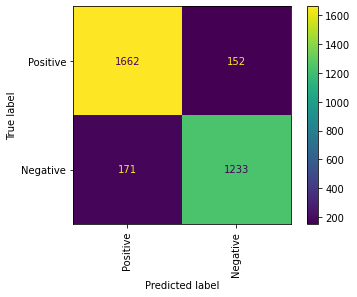

In [82]:
# fig,ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df_val.label.values,df_val.predicted_label.values,
                                        display_labels=['Positive','Negative'],xticks_rotation='vertical')

## Most confident prediction: right vs wrong

In [83]:
def _get_prob_match(row):
    l = row['label']
    prob = row['predicted_probability']
    return prob[l]
def _get_prob_mismatch(row):
    prob = row['predicted_probability']
    return np.max(prob)

In [84]:
df_val['correct_confidence'] = df_val.loc[df_val.label==df_val.predicted_label].apply(_get_prob_match,axis=1)

In [85]:
df_val['incorrect_confidence'] = df_val.loc[df_val.label!=df_val.predicted_label].apply(_get_prob_mismatch,axis=1)

In [86]:
def analyze_correct_pred(df,cols=['text','label_str','correct_confidence'],ascending=False,top_n=5):
    raw_tmp = df.sort_values('correct_confidence',ascending=ascending)[cols].head(top_n).values
    for tmp in raw_tmp:
        print(' | '.join(tmp[0]))
        print(tmp[1:])
        print('-'*100)
def analyze_incorrect_pred(df,cols=['text','label_str','predicted_label_str','incorrect_confidence'],ascending=False,top_n=5):
    raw_tmp = df.sort_values('incorrect_confidence',ascending=ascending)[cols].head(top_n).values
    for tmp in raw_tmp:
        print(' | '.join(tmp[0]))
        print(f'True label: {tmp[1]}, but predict {tmp[2]}, with confidence {tmp[3]}')
        print('-'*100)

In [89]:
analyze_correct_pred(df_val,ascending=True,top_n=20)

Mua | ao | mua | bo_shop | giao | ao | mua | doi | LAM | sao | DANH_Giá | the | nao | day
['Negative' 0.5087628960609436]
----------------------------------------------------------------------------------------------------
Bông | mềm | hơn | nhưng | cũng | mỏng | hơn | đợt | trước | dùng
['Positive' 0.5093692541122437]
----------------------------------------------------------------------------------------------------
Ghi | date | T2 | / | 2019 | nên | mới | đặt_hàng | đến | 5 | gói | nhận | hàng | thì | T1 | / | 2019 | thực_phẩm | cho | bé | nên | bán | đúng_hạn | sử_dụng | giới_thiệu | để | khách | tin_tưởng | & | quyết_định | mua | hàng
['Negative' 0.5200026035308838]
----------------------------------------------------------------------------------------------------
Pin | tụt | nhanh | nhưng | không | bị | sập | nguồn
['Positive' 0.5242894887924194]
----------------------------------------------------------------------------------------------------
Mở_ra | có | mỗi | vỏ | ko | thấy

In [90]:
analyze_incorrect_pred(df_val,ascending=False,top_n=20)

. | Hàng | rất | đẹp | <3 | !
True label: Negative, but predict Positive, with confidence 0.9974151849746704
----------------------------------------------------------------------------------------------------
Tam | duoc | Đóng_gói | sản_phẩm | rất | đẹp | và | chắc_chắn | Đóng_gói | sản_phẩm | rất | đẹp | và | chắc_chắn
True label: Negative, but predict Positive, with confidence 0.997407853603363
----------------------------------------------------------------------------------------------------
Chất_lượng | sản_phẩm | tuyệt_vời | Đóng_gói | sản_phẩm | rất | đẹp | và | chắc_chắn | Shop | phục_vụ | rất | tốt | Thời_gian | giao | hàng | chậm | Rất | đáng | tiền | Thời_gian | giao | hàng | chậm
True label: Negative, but predict Positive, with confidence 0.997378945350647
----------------------------------------------------------------------------------------------------
Chất_lượng | sản_phẩm | tuyệt_vời | nhưng | toàn | chữ | Trung_Quốc | .
True label: Negative, but predict Positive, wit

In [91]:
analyze_incorrect_pred(df_val,ascending=True,top_n=20)

Khẩu_vị | của | mình | thì | hơi | nhạt | và | thiếu | cay | :)
True label: Positive, but predict Negative, with confidence 0.5006212592124939
----------------------------------------------------------------------------------------------------
Đóng_gói | đẹp | . | Nhưng | pin | ko | bền | . | Nạp | sạc | dự_phòng | cả | đêm | mới | đầy | mà | Sạc | chỉ | dc | 1 | lần | là | hết | . | - | _ | -
True label: Positive, but predict Negative, with confidence 0.5072213411331177
----------------------------------------------------------------------------------------------------
Chất_lượng | của | sản_phẩm | phù_hợp | với | giá | tiền | . | Có_thể | hãng | cần | nghiên_cứu | sao | cho | cục | sạc | ít | nóng | trong | quá_trình | sạc | vì | hiện_nay | khi | sạc | cục | sạc | rất | nóng | nên | tâm_lý | người | sử_dụng | sợ | nó | cháy | nổ | .
True label: Negative, but predict Positive, with confidence 0.5155402421951294
--------------------------------------------------------------------------